# Dataset

In [1]:
from IPython.display import Audio
import glob
import os
import torchaudio
import torch
import torch.nn as nn
import ast
from tqdm.auto import tqdm
import numpy as np

from torch.optim import Adam

from accelerate import Accelerator
from huggingface_hub import create_repo
from tqdm.auto import tqdm
from pathlib import Path
import torch.nn.functional as F
import os

from accelerate.utils import ProjectConfiguration

from diffusers.optimization import get_cosine_schedule_with_warmup

from torchtune.modules import RMSNorm

In [2]:
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
import os
from dotenv import load_dotenv
import wandb

load_dotenv(dotenv_path='variables.env')
wandb.login(key=os.environ["WANDB_API_KEY"])

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find pav-ser.
wandb: Currently logged in as: paulovsantanas (paulovsantanasteam). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/paulosantana/.netrc


True

In [4]:
# !wget https://zenodo.org/record/5427549/files/emoUERJ.zip

In [5]:
# %%capture
# !unzip emoUERJ.zip

In [6]:
DATASET_DIR='emoUERJ'
DEVICE='cuda'

In [7]:
class EmoUERJFeatureDataset(torch.nn.Module):
    """
    Position 1: actor's gender ('m' for man or 'w' for woman)
    Positions 2 and 3: actor's id (from 01 to 04)
    Position 4: emotion (h: happiness, a: anger, s: sadness, n: neutral)
    Positions 5 and 6: recording identification
    """

    def __init__(
        self,
        labels=["h", "a", "s", "n"],
        actor_ids=[1, 2, 3, 4],
        data_path=DATASET_DIR,
        device=DEVICE,
    ):
        super().__init__()

        self.DEVICE = device
        self.all_file_paths = glob.glob(
            os.path.join(data_path, "**", "*.pt"), recursive=True
        )
        # Filtra o dataset por atores (útil para criar conjuntos de teste e validação)
        self.actor_ids = actor_ids
        self.file_paths = list(
            filter(
                lambda fp: int(os.path.basename(fp)[2]) in actor_ids,
                self.all_file_paths,
            )
        )
        self.labels = labels

    @property
    def num_labels(self):
        return len(self.labels)

    def get_label_id(self, label):
        return self.labels.index(label)

    def _get_label_by_fp(self, fp):
        name = os.path.basename(fp)
        label = name[3]
        return label

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        fp = self.file_paths[index]
        label_id = self.get_label_id(self._get_label_by_fp(fp))
        feature = torch.load(fp)
        return feature, int(label_id)

In [8]:
class EmoUERJDataset(torch.nn.Module):
    """
    Position 1: actor's gender ('m' for man or 'w' for woman)
    Positions 2 and 3: actor's id (from 01 to 04)
    Position 4: emotion (h: happiness, a: anger, s: sadness, n: neutral)
    Positions 5 and 6: recording identification
    """

    def __init__(
        self,
        feature_extractor,
        labels=["h", "a", "s", "n"],
        actor_ids=[1, 2, 3, 4],
        data_path=DATASET_DIR,
        device=DEVICE,
    ):
        super().__init__()

        self.DEVICE = device
        self.all_file_paths = glob.glob(
            os.path.join(data_path, "**", "*.wav"), recursive=True
        )
        # Filtra o dataset por atores (útil para criar conjuntos de teste e validação)
        self.actor_ids = actor_ids
        self.file_paths = list(
            filter(
                lambda fp: int(os.path.basename(fp)[2]) in actor_ids,
                self.all_file_paths,
            )
        )
        self.labels = labels
        self.feature_extractor = feature_extractor

    @property
    def num_labels(self):
        return len(self.labels)

    def get_label_id(self, label):
        return self.labels.index(label)

    def _get_label_by_fp(self, fp):
        name = os.path.basename(fp)
        label = name[3]
        return label

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        fp = self.file_paths[index]
        label_id = self.get_label_id(self._get_label_by_fp(fp))
        feature = self.feature_extractor(fp)
        return torch.Tensor(feature).float(), int(label_id), os.path.splitext(os.path.basename(fp))[0]

In [9]:
import random
import torch
import librosa
from torchaudio.transforms import (
    Resample,
    Spectrogram,
    MelSpectrogram,
    TimeStretch,
    FrequencyMasking,
    TimeMasking,
    MelScale,
)
from torchaudio.functional import detect_pitch_frequency


class Preprocessing(torch.nn.Module):
    def __init__(
        self, duration: float = 7, input_freq: int = 44100, resample_freq: int = 16000
    ):
        super().__init__()
        self.num_samples = int(duration * resample_freq)
        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

    def _to_mono(self, waveform):
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

    def _cut_if_necessary(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[1] > self.num_samples:
            waveform = waveform[:, : self.num_samples]
        return waveform

    def _right_pad_if_necessary(self, waveform: torch.Tensor) -> torch.Tensor:
        num_samples = waveform.shape[1]
        if num_samples < self.num_samples:
            num_missing_samples = self.num_samples - num_samples
            last_dim_padding = (0, num_missing_samples)
            waveform = torch.nn.functional.pad(waveform, last_dim_padding)
        return waveform

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        preprocessed_waveform = self.resample(self._to_mono(waveform))
        preprocessed_waveform = self._cut_if_necessary(preprocessed_waveform)
        preprocessed_waveform = self._right_pad_if_necessary(preprocessed_waveform)
        return preprocessed_waveform


class MelFeatureExtractor(torch.nn.Module):
    def __init__(self, n_fft: int = 1024, n_mels: int = 80, sample_rate: int = 16000):
        super().__init__()

        self.spec = Spectrogram(n_fft=n_fft, power=2)

        self.spec_aug = torch.nn.Sequential(
            FrequencyMasking(freq_mask_param=80),
            TimeMasking(time_mask_param=80),
        )

        self.mel_scale = MelScale(
            n_mels=n_mels, sample_rate=sample_rate, n_stft=n_fft // 2 + 1
        )

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spec(waveform)
        spec = self.spec_aug(spec)
        mel = self.mel_scale(spec)

        return mel


class ModelFeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        model,
    ):
        super().__init__()
        self.model = model

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        features, _ = self.model.extract_features(waveform)

        return features[-1]
    
class NoopExtractor(torch.nn.Module):
    def __init__(
        self,
    ):
        super().__init__()

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return waveform

In [35]:
class FileToFeature(torch.nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.preprocess = Preprocessing()
        self.extract_feature = feature_extractor

    def forward(self, fp: str) -> torch.Tensor:
        x, sr = torchaudio.load(fp)
        x = self.preprocess(x)
        return self.extract_feature(x)

## Melspectrogram example

In [11]:
# import librosa
# import matplotlib.pyplot as plt

# def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
#     fig, axs = plt.subplots(1, 1)
#     axs.set_title(title or "Spectrogram (db)")
#     axs.set_ylabel(ylabel)
#     axs.set_xlabel("frame")
#     im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
#     fig.colorbar(im, ax=axs)
#     plt.show(block=False)

In [12]:
# dataset = EmoUERJDataset(
#     FileToFeature(MelFeatureExtractor()),
#     actor_ids=[1, 2, 4]
# )

# plot_spectrogram(dataset[4][0][0])

## Balanceamento entre as classes

In [13]:
# import pandas as pd

# dataset = EmoUERJDataset(
#     FileToFeature(NoopExtractor()),
#     actor_ids=[1, 2, 4]
# )
# temp = [{"class": data[1]} for data in dataset]
# df = pd.DataFrame(temp)
# df['class'].value_counts()

## Melspectrogram

In [29]:
melspec_train_dataset = EmoUERJDataset(
    FileToFeature(MelFeatureExtractor()),
    actor_ids=[1, 2]
)
print(f"Total train files: {len(melspec_train_dataset)}")
melspec_valid_dataset = EmoUERJDataset(
    FileToFeature(MelFeatureExtractor()),
    actor_ids=[3, 4]
)
print(f"Total validation files: {len(melspec_valid_dataset)}")

Total train files: 185
Total validation files: 192


In [30]:
train_dataloader = torch.utils.data.DataLoader(
    melspec_train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=8
)
validation_dataloader = torch.utils.data.DataLoader(
    melspec_valid_dataset,
    batch_size=8
)

## WavLM Features

In [16]:
wavlm_train_dataset = EmoUERJFeatureDataset(
    data_path='emoUERJ_wavlm_features',
    actor_ids=[1, 2]
)
wavlm_valid_dataset = EmoUERJFeatureDataset(
    data_path='emoUERJ_wavlm_features',
    actor_ids=[3, 4]
)

## Hubert Features

In [17]:
hubert_train_dataset = EmoUERJFeatureDataset(
    data_path='emoUERJ_hubert_features',
    actor_ids=[1, 2]
)
hubert_valid_dataset = EmoUERJFeatureDataset(
    data_path='emoUERJ_hubert_features',
    actor_ids=[3, 4]
)

## wav2vec2 Features

In [18]:
wav2vec2_train_dataset = EmoUERJFeatureDataset(
    data_path='emoUERJ_wav2vec2_features',
    actor_ids=[1, 2]
)
wav2vec2_valid_dataset = EmoUERJFeatureDataset(
    data_path='emoUERJ_wav2vec2_features',
    actor_ids=[3, 4]
)

# Training

In [19]:
project_config = ProjectConfiguration(
    total_limit=5,  # Keep only the latest 10 checkpoints
    automatic_checkpoint_naming=True  # Enable automatic naming
)

In [20]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:

    def __init__(self, model_name):
        self.model_name = model_name

        self.output_dir = f"models/{self.model_name}"
        self.hub_model_id = f"paulovsantanas/{self.model_name}"

    train_batch_size = 64
    # eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 10
    save_model_steps = 10
    mixed_precision = "fp16"
    # output_dir = f"models/{self.model_name}"  # the model name locally and on the HF Hub
    # push_to_hub = False  # whether to upload the saved model to the HF Hub
    # hub_model_id = f"paulovsantanas/{self.model_name}"  # the name of the repository to create on the HF Hub
    # hub_private_repo = True
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
    # max_train_samples = 50000

In [21]:
import uuid


def train_accelerate(
    model,
    optimizer,
    lr_scheduler,
    criterium,
    train_dataloader,
    validation_dataloader,
    config: TrainingConfig,
    project_config: ProjectConfiguration,
):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb",
        project_dir=os.path.join(config.output_dir),
        project_config=project_config,
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers(
            "pav-ser",
            init_kwargs={"wandb": {"name": f"{config.model_name}_{uuid.uuid4()}"}},
        )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    progress_bar = tqdm(
        total=config.num_epochs, disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description(f"Epoch")

    global_step = 0

    # Train
    for epoch in range(config.num_epochs):
        epoch_acc = []
        epoch_loss = []
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(model):
                model.train()

                audio = batch[0].to(DEVICE)
                labels = batch[1].to(DEVICE)

                optimizer.zero_grad()
                outputs = model(audio)

                loss = criterium(outputs, labels)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)

                optimizer.step()
                lr_scheduler.step()

                global_step += 1
                logs = {}

                # Evaluate
                model.eval()
                with torch.no_grad():
                    # Train metrics
                    epoch_loss.append(loss.float().cpu().item())

                    preds = torch.argmax(
                        torch.nn.functional.softmax(outputs, dim=-1), dim=-1
                    )
                    epoch_acc.extend((preds == labels).float().cpu().numpy())

                    epoch_avg_loss = sum(epoch_loss) / len(epoch_loss)
                    epoch_avg_acc = sum(epoch_acc) / len(epoch_acc)

                    logs = {
                        "Train Average Loss": epoch_avg_loss,
                        "Train Average Accuracy": epoch_avg_acc,
                    }

                    # Validation metrics
                    if step == len(train_dataloader) - 1:
                        validation_loss = []
                        validation_acc = []
                        for audio, labels in validation_dataloader:
                            audio = audio.to(DEVICE)
                            labels = labels.to(DEVICE)

                            validation_outputs = model(audio)
                            validation_loss.append(
                                criterium(validation_outputs, labels)
                                .float()
                                .cpu()
                                .item()
                            )

                            validation_preds = torch.argmax(
                                torch.nn.functional.softmax(validation_outputs, dim=-1),
                                dim=-1,
                            )
                            validation_acc.extend(
                                (validation_preds == labels).float().cpu().numpy()
                            )

                        validation_avg_loss = sum(validation_loss) / len(
                            validation_loss
                        )
                        validation_avg_acc = sum(validation_acc) / len(validation_acc)

                        logs["Validation Average Loss"] = validation_avg_loss
                        logs["Validation Average Accuracy"] = validation_avg_acc

                logs["lr"] = lr_scheduler.get_last_lr()[0]
                logs["step"] = global_step + 1
                # logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step+1}
                accelerator.log(logs, step=global_step)
                # progress_bar.set_postfix(**logs)

            if accelerator.is_main_process:
                if (global_step + 1) % config.save_model_steps == 0 or global_step == (
                    config.num_epochs * len(train_dataloader)
                ) - 1:
                    accelerator.save_state(config.output_dir)
        progress_bar.update(1)
    accelerator.end_training()

## CNN 2D

### Definition

In [32]:
class Conv2DBlock(nn.Module):
    def __init__(self,
                 config,
                 in_channels=1,
                 out_channels=32,
                 kernel_size=(3, 3)):
        # Inicializa a classe Conv2DBlock que herda de nn.Module
        super(Conv2DBlock, self).__init__()
        # Atributos da classe
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Define a operação de convolução
        self.conv = nn.Conv2d(
            self.in_channels,
            self.out_channels,
            stride=config["stride"],
            kernel_size=kernel_size
        )

        # Define o tipo de normalização que será utilizado
        if config["norm"] == "group_normalization":
            self.norm = nn.GroupNorm(self.in_channels, self.out_channels)
        elif config["norm"] == "batch_normalization":
            self.norm = nn.BatchNorm2d(self.out_channels)
        elif config["norm"] == "instance_normalization":
            self.norm = nn.InstanceNorm2d(self.out_channels)
        else:
            self.norm = None

        # Define a função de ativação que será utilizada
        if config["activation"] == "relu":
            self.activation = nn.ReLU()
        elif config["activation"] == "mish":
            self.activation = nn.Mish()
        else:
            raise ValueError(f"Unsupported activation: {config.activation}")

        # Define o tipo de pooling que será utilizado
        if config["pooling"]:
            self.pooling = nn.MaxPool2d(tuple(config["pooling_ks"]))
        else:
            self.pooling = None

        # Define a técnica de regularização que será utilizada
        if config["dropout"] > 0:
            self.dropout = nn.Dropout2d(config["dropout"])
        else:
            self.dropout = None

    def forward(self, x):
        # x: [B, 1, T, num_feature]
        x = self.conv(x)
        # x: [B, n_filters, T, num_feature]
        if self.norm is not None:
            x = self.norm(x)
        x = self.activation(x)
        if self.pooling:
            x = self.pooling(x)
        if self.dropout:
            x = self.dropout(x)
        # x: [B, n_filters, T, num_feature]
        return x
    
class SERCNN2D(nn.Module):
    def __init__(self, config):
        super(SERCNN2D, self).__init__()

        # Setup convolutional blocks
        conv_block_kernels = config["conv_block_kernels"] # Lista de tamanhos de kernel para as camadas convolucionais
        conv_block_kernels.reverse() # Inverte a lista para começar com o menor kernel
        # Cria a primeira camada convolucional
        init_layer = Conv2DBlock(config["conv_block"],
                                  out_channels=config["conv_block_dims"][0],
                                  kernel_size=tuple(conv_block_kernels.pop()))
        conv_blocks = [init_layer] # Lista para armazenar as camadas convolucionais
        inc = config["conv_block_dims"][0] # Número de canais de entrada para a próxima camada
        # Cria as outras camadas convolucionais
        for dim in config["conv_block_dims"][1:]:
            kernel_size = tuple(conv_block_kernels.pop())
            conv_blocks.append(Conv2DBlock(config["conv_block"],
                                            kernel_size=kernel_size,
                                            in_channels=inc,
                                            out_channels=dim))
            inc = dim
        self.conv_blocks_module = nn.Sequential(*conv_blocks)

        # Setup linear layers
        _input = torch.zeros(torch.Size(ast.literal_eval(config["input_size"]))).unsqueeze(0)

        # Cria um tensor para determinar o tamanho de entrada da camada totalmente conectada 1
        dummy_tensor = self.conv_blocks_module(_input)
        fc1_in = 1
        for s in dummy_tensor.size()[1:]:
            fc1_in *= s

        # Função para criar uma camada linear com as especificações dadas
        def setup_linear_block(cfg, in_channels):
            block = []

            block = []
            dim = cfg["dim"]
            block.append(nn.Linear(in_channels, dim))
            if cfg["dropout"] > 0:
                block.append(nn.Dropout(cfg["dropout"]))
            if cfg["activation"] == "relu":
                block.append(nn.ReLU())
            else:
                raise ValueError(f'Unsupported activation: {cfg["activation"]}')

            return nn.Sequential(*block), dim

        # Cria as camadas totalmente conectadas
        self.fc1, fc2_in = setup_linear_block(config["fc1"], fc1_in)
        self.fc2, out_in = setup_linear_block(config["fc2"], fc2_in)

        # Camada de projeção para a saída
        self.proj = nn.Linear(out_in, config["num_labels"])

    def forward(self, x):
        # Passa o sinal de entrada pelas camadas convolucionais
        x = self.conv_blocks_module(x)

        # Transforma o tensor resultante em um vetor
        x = x.view(x.size(0), -1)
        # Passa o vetor pela camada totalmente conectada 1
        x = self.fc1(x)
        # Passa o vetor pela camada totalmente conectada 2
        x = self.fc2(x)

        # Passa o vetor pela camada de projeção para obter a saída
        return self.proj(x)

### Train

In [33]:
config = {
        "input_size": '(1, 80, 219)',
        "conv_block": {
            "dropout": 0.25,
            "norm": "batch_normalization",
            "activation": "mish",
            "pooling": True,
            "pooling_ks": [2, 2],
            "stride": 1
        },
        "fc1": {
            "dim": 512,
            "activation": "relu",
            "dropout": 0.25
        },
        "fc2": {
            "dim": 256,
            "activation": "relu",
            "dropout": 0.25
        },
        "conv_block_kernels": [[3, 3], [3, 3], [3, 3]],
        "conv_block_dims": [64, 32, 16],
        "num_labels": 4
}

cnn2d_training_config = TrainingConfig('pav-cnn2d-ser')
cnn2d_training_config.num_epochs = 50
cnn2d_training_config.lr_warmup_steps = 100
cnn2d_training_config.train_batch_size = 8
cnn2d_training_config.save_model_steps = 50
cnn2d_training_config.learning_rate = 1e-4

cnn2d_model = SERCNN2D(config)
cnn2d_optimizer = torch.optim.AdamW(cnn2d_model.parameters(), lr=cnn2d_training_config.learning_rate)
cnn2d_lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=cnn2d_optimizer,
    num_warmup_steps=cnn2d_training_config.lr_warmup_steps,
    num_training_steps=cnn2d_training_config.num_epochs*len(train_dataloader),
)
cnn2d_criterium = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary

summary(cnn2d_model, (1, 80, 219))

In [ ]:
train_accelerate(
    cnn2d_model,
    cnn2d_optimizer,
    cnn2d_lr_scheduler,
    cnn2d_criterium,
    train_dataloader,
    validation_dataloader,
    cnn2d_training_config,
    project_config,
)

## MLP

### Definition

In [23]:
class MLPLayerNorm(nn.Module):
    def __init__(self, num_layers, input_dim, output_dim, hidden_size=200, hidden_dropout=0.1) -> None:
        super().__init__()

        self.flatten = nn.Flatten()
        self.input_proj = self.__create_linear_block(input_dim, hidden_size, hidden_dropout)

        if num_layers:
            self.hidden_layers = []
            for i in range(num_layers):
                self.hidden_layers.append(
                    self.__create_linear_block(hidden_size, hidden_size, hidden_dropout)
                )
            self.hidden_layers = nn.Sequential(*self.hidden_layers)
        self.output_proj = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = self.input_proj(x)
        x = self.hidden_layers(x)
        y = self.output_proj(x)

        return y
    
    def __create_linear_block(self, input_dim, output_dim, hidden_dropout):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LayerNorm(output_dim),
            nn.Dropout(hidden_dropout),
            nn.ReLU()
        )

### WavLM

#### Train

In [45]:
mlp_training_config = TrainingConfig('mlp-wavlm')
mlp_training_config.num_epochs = 50
mlp_training_config.lr_warmup_steps = 100
mlp_training_config.train_batch_size = 8
mlp_training_config.save_model_steps = 50
mlp_training_config.learning_rate = 1e-6

wavlm_train_dataloader = torch.utils.data.DataLoader(
    wavlm_train_dataset,
    shuffle=True,
    batch_size=mlp_training_config.train_batch_size
)
wavlm_validation_dataloader = torch.utils.data.DataLoader(
    wavlm_valid_dataset,
    batch_size=8
)

dimensions_wavlm = wavlm_train_dataloader.dataset[0][0].size()
mlp_model = MLPLayerNorm(
    num_layers=2,
    input_dim=(dimensions_wavlm[1] * dimensions_wavlm[2]),
    output_dim=4,
    hidden_size=200,
    hidden_dropout=0.2,
    )

mlp_model.to(DEVICE)
mlp_optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=mlp_training_config.learning_rate)
mlp_lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=mlp_optimizer,
    num_warmup_steps=mlp_training_config.lr_warmup_steps,
    num_training_steps=mlp_training_config.num_epochs*len(wavlm_train_dataloader),
)
mlp_criterium = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary

summary(mlp_model)

In [ ]:
train_accelerate(
    mlp_model,
    mlp_optimizer,
    mlp_lr_scheduler,
    mlp_criterium,
    wavlm_train_dataloader,
    wavlm_validation_dataloader,
    mlp_training_config,
    project_config,
)

### HuBERT

#### Train

In [23]:
mlp_training_config = TrainingConfig('mlp-hubert')
mlp_training_config.num_epochs = 50
mlp_training_config.lr_warmup_steps = 100
mlp_training_config.train_batch_size = 8
mlp_training_config.save_model_steps = 50
mlp_training_config.learning_rate = 1e-6

hubert_train_dataloader = torch.utils.data.DataLoader(
    hubert_train_dataset,
    shuffle=True,
    batch_size=mlp_training_config.train_batch_size
)
hubert_validation_dataloader = torch.utils.data.DataLoader(
    hubert_valid_dataset,
    batch_size=8
)

dimensions_hubert = hubert_train_dataloader.dataset[0][0].size()
mlp_model = MLPLayerNorm(
    num_layers=2,
    input_dim=(dimensions_hubert[1] * dimensions_hubert[2]),
    output_dim=4,
    hidden_size=200,
    hidden_dropout=0.2,
    )

mlp_model.to(DEVICE)
mlp_optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=mlp_training_config.learning_rate)
mlp_lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=mlp_optimizer,
    num_warmup_steps=mlp_training_config.lr_warmup_steps,
    num_training_steps=mlp_training_config.num_epochs*len(hubert_train_dataloader),
)
mlp_criterium = nn.CrossEntropyLoss()

In [24]:
train_accelerate(
    mlp_model,
    mlp_optimizer,
    mlp_lr_scheduler,
    mlp_criterium,
    hubert_train_dataloader,
    hubert_validation_dataloader,
    mlp_training_config,
    project_config,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Average Accuracy,▁▂▃▄▆▇▇█████████████████████████████████
Train Average Loss,█▇▇▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Average Accuracy,▁▂▃▃▆▅▆▇▇▇██▇█▇█████████▇█▇▇████████████
Validation Average Loss,█▇▇▇▅▅▅▄▄▃▃▃▂▂▃▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▂▃▅███████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Average Accuracy,1.0
Train Average Loss,0.29495
Validation Average Accuracy,0.69792
Validation Average Loss,0.82822
lr,0.0


### wav2vec2

#### Train

In [26]:
mlp_training_config = TrainingConfig('mlp-wav2vec2-hs200')
mlp_training_config.num_epochs = 50
mlp_training_config.lr_warmup_steps = 100
mlp_training_config.train_batch_size = 8
mlp_training_config.save_model_steps = 50
mlp_training_config.learning_rate = 1e-6

wav2vec2_train_dataloader = torch.utils.data.DataLoader(
    wav2vec2_train_dataset,
    shuffle=True,
    batch_size=mlp_training_config.train_batch_size
)
wav2vec2_validation_dataloader = torch.utils.data.DataLoader(
    wav2vec2_valid_dataset,
    batch_size=8
)

dimensions_wav2vec2 = wav2vec2_train_dataloader.dataset[0][0].size()
mlp_model = MLPLayerNorm(
    num_layers=2,
    input_dim=(dimensions_wav2vec2[1] * dimensions_wav2vec2[2]),
    output_dim=4,
    hidden_size=200,
    hidden_dropout=0.2,
)

mlp_model.to(DEVICE)
mlp_optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=mlp_training_config.learning_rate)
mlp_lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=mlp_optimizer,
    num_warmup_steps=mlp_training_config.lr_warmup_steps,
    num_training_steps=mlp_training_config.num_epochs*len(wav2vec2_train_dataloader),
)
mlp_criterium = nn.CrossEntropyLoss()

In [27]:
train_accelerate(
    mlp_model,
    mlp_optimizer,
    mlp_lr_scheduler,
    mlp_criterium,
    wav2vec2_train_dataloader,
    wav2vec2_validation_dataloader,
    mlp_training_config,
    project_config,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Average Accuracy,▁▁▃▄▅▄▄▅▆▇▆▇▇▇██████████████████████████
Train Average Loss,██▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Average Accuracy,▁▂▂▂▃▄▄▃▅▅▆▅▆▆▇▆▆▇▇▇▇█▇███▇▇█▇██▇██▇████
Validation Average Loss,██▇▇▇▇▆▆▄▅▃▃▂▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▂▃▅███████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Average Accuracy,1.0
Train Average Loss,0.31673
Validation Average Accuracy,0.63021
Validation Average Loss,0.9282
lr,0.0


# Ablation

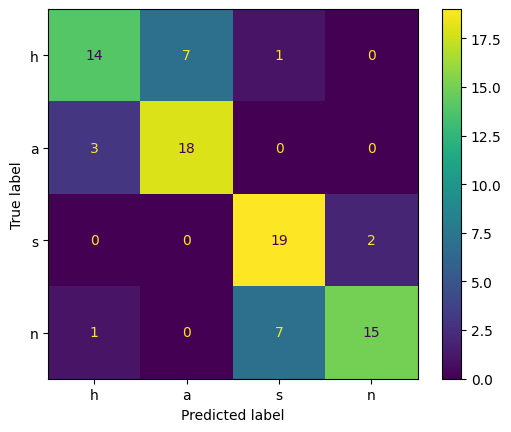

In [42]:
from sklearn import metrics
import matplotlib.pyplot as plt

validation_preds = []
validation_labels = []
for features_1, labels in hubert_validation_dataloader:
    features_1 = features_1.to(DEVICE)
    labels = labels

    validation_outputs = mlp_model(features_1)

    validation_preds.extend(
        torch.argmax(
            torch.nn.functional.softmax(validation_outputs, dim=-1),
            dim=-1,
        ).cpu().numpy()
    )
    validation_labels.extend(labels)

confusion_matrix = metrics.confusion_matrix(validation_labels, validation_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["h", "a", "s", "n"])
cm_display.plot()
plt.show()

# Processing features WavLM

In [9]:
bundle_wavlm = torchaudio.pipelines.WAVLM_LARGE
wavlm = bundle_wavlm.get_model()

In [37]:
# wavlm_dataset = EmoUERJDataset(
#     FileToFeature(ModelFeatureExtractor(wavlm))
# )
wavlm_train_dataset[0][0].size()

torch.Size([1, 349, 1024])

In [23]:
folder = 'emoUERJ_wavlm_features'
os.makedirs(folder, exist_ok=True)

for x, y, filename in tqdm(wavlm_dataset):
    torch.save(x, f"{folder}/{filename}.pt", _use_new_zipfile_serialization=False)

  0%|          | 0/377 [00:00<?, ?it/s]

# Processing features HuBERT

In [10]:
bundle_hubert = torchaudio.pipelines.HUBERT_XLARGE
hubert = bundle_hubert.get_model()

In [35]:
hubert_dataset = EmoUERJDataset(
    FileToFeature(ModelFeatureExtractor(hubert))
)

In [32]:
hubert_dataset[0][0].size()

torch.Size([1, 349, 1280])

In [36]:
folder = 'emoUERJ_hubert_features'
os.makedirs(folder, exist_ok=True)

for x, y, filename in tqdm(hubert_dataset):
    torch.save(x, f"{folder}/{filename}.pt", _use_new_zipfile_serialization=False)

  0%|          | 0/377 [00:00<?, ?it/s]

# Processing features wave2vec2

In [6]:
bundle_wav2vec2 = torchaudio.pipelines.WAV2VEC2_XLSR_2B
wav2vec2 = bundle_wav2vec2.get_model()

In [8]:
wav2vec2_dataset = EmoUERJDataset(
    FileToFeature(ModelFeatureExtractor(wav2vec2))
)

In [9]:
wav2vec2_dataset[0][0].size()

torch.Size([1, 349, 1920])

In [10]:
folder = 'emoUERJ_wav2vec2_features'
os.makedirs(folder, exist_ok=True)
# wav2vec2.to('cpu')

for x, y, filename in tqdm(wav2vec2_dataset):
    # x.to(DEVICE)
    torch.save(x, f"{folder}/{filename}.pt", _use_new_zipfile_serialization=False)

  0%|          | 0/377 [00:00<?, ?it/s]